In [173]:
import numpy as np 
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn.preprocessing import (StandardScaler, LabelEncoder)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn import svm

#Neural Network
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense
from keras_tqdm import TQDMNotebookCallback
from keras import regularizers


Using TensorFlow backend.


In [156]:
train_vals = pd.read_csv('../data/training_vals.csv')
train_labels = pd.read_csv('../data/training_labels.csv')
test_vals = pd.read_csv('../data/test_vals.csv')

In [157]:
#To make my train_test split easier later on: 
train_vals.set_index('id', inplace=True)
train_labels.set_index('id', inplace=True)

In [158]:
#For convenience
train_vals = train_vals.merge(train_labels, left_index=True, right_index=True)

In [159]:
train_vals.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [160]:
cols_to_keep = ['amount_tsh', 'gps_height', 'region_code', 'population',
               'permit', 'extraction_type_class', 
               'management_group', 'payment_type', 'quality_group', 
                'quantity_group', 'source_class', 'waterpoint_type_group', 'status_group']

In [161]:
#Relevant cols kept, rest ditched
train_kept = train_vals[cols_to_keep]

In [162]:
#Very few actual nans left, so dump them to be safe: 
train_kept = train_kept.dropna(how='any')

In [163]:
#We have a bunch of columns to convert that aren't numeric yet:
cols_to_convert = ['permit', 'extraction_type_class', 'management_group', 'payment_type', 'quality_group', 
                'quantity_group', 'source_class', 'waterpoint_type_group', 'status_group']

In [164]:
#Actual conversion: 
le = LabelEncoder()
for colname in cols_to_convert:
    train_kept[colname] = le.fit_transform(train_kept[colname])
    
#Status group: 
# 0 = functional
# 2 = not functional
# 1 = needs repair

In [165]:
train_kept.head()

,amount_tsh,gps_height,region_code,population,permit,extraction_type_class,management_group,payment_type,quality_group,quantity_group,source_class,waterpoint_type_group,status_group
id,,,,,,,,,,,,,
69572,6000.0,1390,11,109,0,0,4,0,2,1,0,1,0
8776,0.0,1399,20,280,1,0,4,2,2,2,1,1,0
34310,25.0,686,21,250,1,0,4,5,2,1,1,1,0
67743,0.0,263,90,58,1,5,4,2,2,0,0,1,2
19728,0.0,0,18,0,1,0,1,2,2,3,1,1,0


In [174]:
X = train_kept.iloc[:, :-1]
y = train_kept.iloc[:, -1]

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [177]:
#Scale X AFTER splitting to avoid information leak
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [178]:
X_train.shape

(39440, 12)

In [255]:
epochs=30
batch_size=32

In [256]:
model = Sequential()
model.add(Dense(12, activation='tanh', input_shape=(12, )))
model.add(Dense(6, activation='tanh', input_shape=(12, )))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [257]:
history = model.fit(X_train, y_train, 
                   batch_size=batch_size, 
                   epochs=epochs,
                   verbose=0, 
                   callbacks=[TQDMNotebookCallback()],
                   validation_data=(X_test, y_test))

In [258]:
scores = model.evaluate(X_test, y_test)

16904/16904 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 18us/step


In [259]:
print("Loss = {}".format(scores[0]))
print("Acc = {}".format(scores[1]))

Loss = 0.672517731355594
Acc = 0.7239115002366304


In [260]:
y_pred = model.predict_classes(X_test)

In [261]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.70      0.90      0.79      9191
          1       0.00      0.00      0.00      1216
          2       0.78      0.61      0.69      6497

avg / total       0.68      0.72      0.69     16904



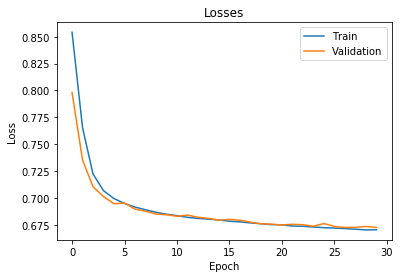

In [262]:
def plot_loss(logs, name='loss'):
    h = logs.history
    plt.plot(logs.epoch, h['loss'], label='Train')
    plt.plot(logs.epoch, h['val_loss'], label='Validation')
    plt.title('Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('{}.png'.format(name), dpi=900)
plot_loss(history, name='loss_underfit')

In [ ]:
#TODO; Different feature selection
#maybe pca instead 
#maybe remove some others
